### 欢迎下载本次GTC in NSI的演示脚本
### 如欲开展接下来的学习，请先准备：
    - WSL运行环境（Debian，ubuntu均可）
    - CUDA驱动程序
    - RAPIDS Conda Env
像这样：

In [90]:
!nvidia-smi

Fri Mar 11 13:17:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.52       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    28W /  N/A |   1753MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

导入如下库

In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import cudf as cf
from timeit import timeit
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import sklearn.linear_model as sl
import cuml.linear_model as cl

In [12]:
# 定义1维矩阵生成测试方法
def cpuGenArray():
    [0 for i in range(1000000)]
def gpuGenArray():
    a = cp.zeros(shape=(1000000,1),dtype=cp.float32)

In [28]:
# 测试速度，其中number参数用于控制测试轮数
cpuResult = round(timeit(cpuGenArray,number=100),2)
gpuResult = round(timeit(gpuGenArray,number=100),2)

In [29]:
cpuResult,gpuResult

(2.1, 0.07)

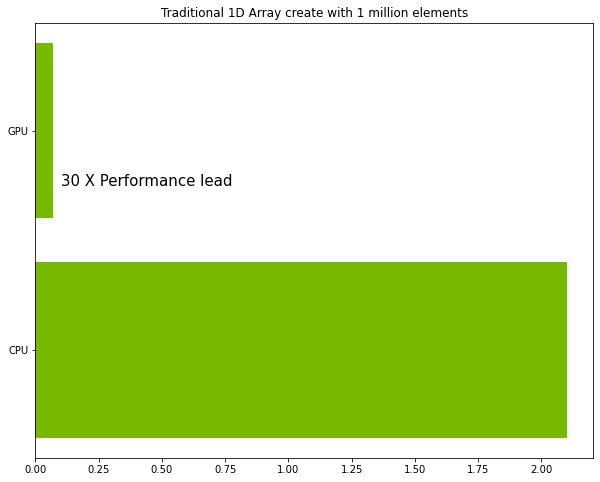

In [33]:
plt.figure(
   figsize=(10,8)
)
plt.title(
    "Traditional 1D Array create with 1 million elements"
)
plt.barh(
    width = [cpuResult,gpuResult],
    y = ['CPU','GPU'],
    color = "#76b900",  
)
plt.text(
    x = 0.10,
    y = 0.75,
    s = f"{round(cpuResult / gpuResult)} X Performance lead",
    fontsize = 15
)
plt.savefig("1DArray.jpg",dpi=500)

In [18]:
# 可以发现，在传统的1维数组创建时，CUDA GPU相比CPU快了整整11倍
# 那么我们来试试更有难度的，矩阵查空：即在充满0/1的二值化矩阵中快速找的有多少个0的存在
# 定义方法
def cpuCheck():
    arr = [random.randint(0,2) for i in range(10000)]
    zeroCount = 0
    for i in range(len(arr)):
        if arr[i] == 0:
            zeroCount += 1
    return zeroCount
def gpuCheck():
    arr = cp.random.randint(low=0,high=2,size=10000)
    zeroCount = 0
    for i in range(len(arr)):
        if arr[i] == 0:
            zeroCount += 1
    return zeroCount

In [99]:
#测试
cpuResult = round(timeit(cpuCheck,number=10),2)
gpuResult = round(timeit(gpuCheck,number=10),2)

In [100]:
cpuResult,gpuResult

(0.06, 17.66)

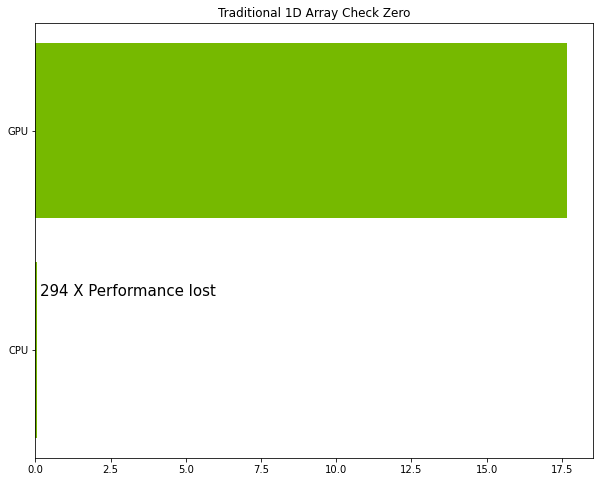

In [101]:
plt.figure(
   figsize=(10,8)
)
plt.title(
    "Traditional 1D Array Check Zero"
)
plt.barh(
    width = [cpuResult,gpuResult],
    y = ['CPU','GPU'],
    color = "#76b900",  
)
plt.text(
    x = 0.15,
    y = 0.25,
    s = f"{round(gpuResult / cpuResult)} X Performance lost",
    fontsize = 15
)
plt.savefig("1DArrayCheck.jpg",dpi=500)

In [88]:
# 什么？cpu比gpu开了整整100倍？
# 这是因为CPU的内存寄存器远比CUDA GPU的来的要大
# 而我们上述使用for来对每一个元素进行筛选的方法就会导致GPU的寄存器不断被刷写
# SRAM的内存空间被不断地迭代，进而在性能上落后了CPU
# 且SRAM中只存储了一个单位的值，本质上也是一种资源浪费

因此我们需要借助算法的力量来使得CUDA充分发挥其性能表现

In [19]:
def cpuCheckNew():
    a = np.random.randint(low=0,high=2,dtype=np.int32,size=10000)
    return np.count_nonzero(a)
def gpuCheckNew():
    a = cp.random.randint(low=0,high=2,dtype=cp.int32,size=10000)
    return cp.count_nonzero(a)

In [20]:
#测试
cpuResult = round(timeit(cpuCheck,number=30),5)
gpuResult = round(timeit(gpuCheckNew,number=30),5)

In [21]:
cpuResult,gpuResult

(0.1991, 0.24263)

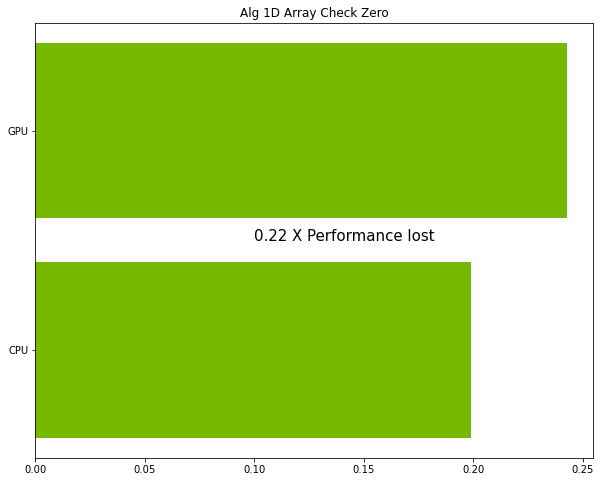

In [25]:
plt.figure(
    figsize=(10,8)
)
plt.title(
    "Alg 1D Array Check Zero"
)
plt.barh(
    width = [cpuResult,gpuResult],
    y = ['CPU','GPU'],
    color = "#76b900",  
)
plt.text(
    x =0.1,
    y = 0.5,
    s = f"{round((gpuResult - cpuResult) / cpuResult,2)} X Performance lost",
    fontsize = 15
)
try:
    plt.savefig("1DArrayCheckAlg.jpg",dpi=500)
except ValueError:
    print("警告！图像像素过大！")

In [219]:
# 这里像素太大了，突破了Matplotlib的上限了

In [122]:
# 可以看到，虽然并没有完全超越CPU，但是在时间上GPU已经几乎赶上了CPU
# 虽然矩阵是数据科学最本质的东西，但我们还是要来写更狠的
# 用GPU读取数据集！

In [123]:
# 方法定义
def cpuRead():
    df = pd.read_csv("amazon.csv")
    return df
def gpuRead():
    df = cf.read_csv("amazon.csv")
    return df

In [225]:
#测试
cpuResult = round(timeit(cpuRead,number=30),2)
gpuResult = round(timeit(gpuRead,number=30),2)

In [226]:
cpuResult,gpuResult

(10.83, 3.37)

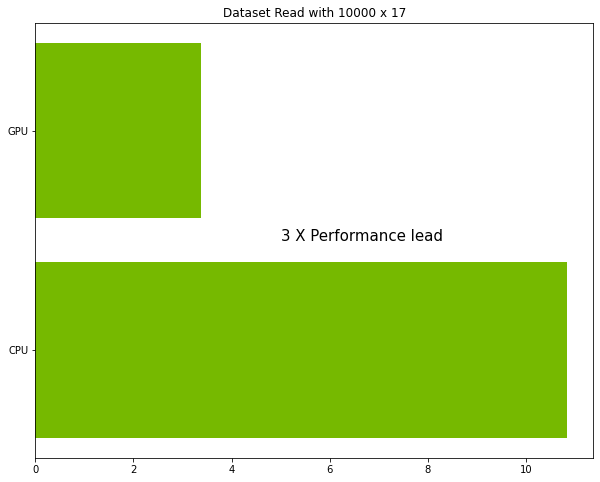

In [227]:
plt.figure(
   figsize=(10,8)
)
plt.title(
    f"Dataset Read with {gpuRead().shape[0]} x {gpuRead().shape[1]}"
)
plt.barh(
    width = [cpuResult,gpuResult],
    y = ['CPU','GPU'],
    color = "#76b900",  
)
plt.text(
    x = 5,
    y = 0.5,
    s = f"{round(cpuResult / gpuResult)} X Performance lead",
    fontsize = 15
)
plt.savefig("DatasetRead.jpg",dpi=500)

In [131]:
# 可以看到，在读取10000条，17列的亚马逊消费预测数据时
# CUDA GPU相较于CPU快了三倍
# 那我们找些有意义的属性来试试预测吧

In [197]:
df = cpuRead()
df.columns

Index(['uniq_id', 'product_name', 'manufacturer', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'amazon_category_and_sub_category',
       'customers_who_bought_this_item_also_bought', 'description',
       'product_information', 'product_description',
       'items_customers_buy_after_viewing_this_item',
       'customer_questions_and_answers', 'customer_reviews', 'sellers'],
      dtype='object')

In [204]:
df['number_of_reviews'] = [float((str(i).replace(",",""))) for i in df['number_of_reviews']]
df['number_of_reviews'].fillna(0,inplace=True)
df['number_of_answered_questions'].fillna(0,inplace=True)

In [220]:
def cpuTrain():
    modle = sl.ElasticNet()
    modle.fit(np.array(df[['number_of_reviews']]),np.array(df[['number_of_answered_questions']]))
def gpuTrain():
    modle = cl.ElasticNet()
    modle.fit(cp.array(df[['number_of_reviews']].astype(cp.float32)),cp.array(df[['number_of_answered_questions']].astype(cp.float32)))

In [229]:
#测试
cpuResult = round(timeit(cpuTrain,number=50),2)
gpuResult = round(timeit(gpuTrain,number=50),2)

In [230]:
cpuResult,gpuResult

(0.64, 0.29)

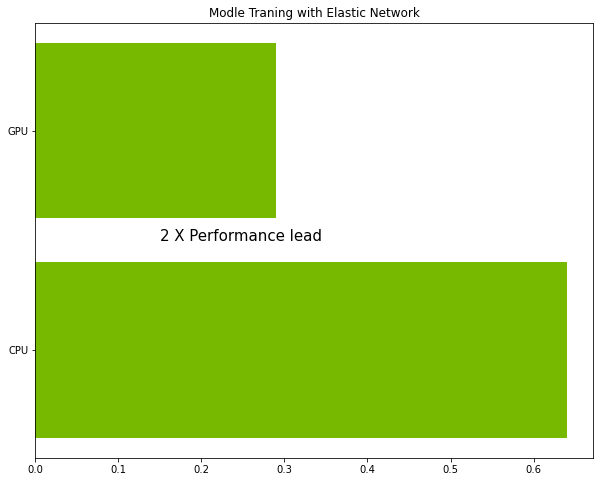

In [231]:
# 可以看到在弹性网络模型的训练中，GPU也是比CPU更快一些的
plt.figure(
   figsize=(10,8)
)
plt.title(
    f"Modle Traning with Elastic Network"
)
plt.barh(
    width = [cpuResult,gpuResult],
    y = ['CPU','GPU'],
    color = "#76b900",  
)
plt.text(
    x = 0.15,
    y = 0.5,
    s = f"{round(cpuResult / gpuResult)} X Performance lead",
    fontsize = 15
)
plt.savefig("ModleTrain.jpg",dpi=500)